In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d manan1717/ocular-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/manan1717/ocular-disease-dataset
License(s): MIT
100% 3.76G/3.78G [00:59<00:00, 17.8MB/s]
100% 3.78G/3.78G [00:59<00:00, 68.6MB/s]


In [ ]:
!unzip -q ocular-disease-dataset.zip

In [ ]:

!mkdir model_data

!mkdir model_data/train
!mkdir model_data/validation
!mkdir model_data/test

# class folders inside train
!mkdir model_data/train/hypertensive
!mkdir model_data/train/normal

# class folders inside validation
!mkdir model_data/validation/hypertensive
!mkdir model_data/validation/normal

# class folders inside test
!mkdir model_data/test/hypertensive
!mkdir model_data/test/normal

In [ ]:
import os
import shutil
import random
import math

original_dir_h = 'preprocessed/H'
original_dir_n = 'preprocessed/N'

new_base_dir = 'model_data'

def split_and_copy_files(original_dir, class_name):

    files = os.listdir(original_dir)
    random.shuffle(files)

    train_split = int(0.8 * len(files))
    validation_split = int(0.9 * len(files))

    train_files = files[:train_split]
    validation_files = files[train_split:validation_split]
    test_files = files[validation_split:]

    # Training files
    for f in train_files:
        shutil.copy(os.path.join(original_dir, f), os.path.join(new_base_dir, 'train', class_name, f))
    # Validation files
    for f in validation_files:
        shutil.copy(os.path.join(original_dir, f), os.path.join(new_base_dir, 'validation', class_name, f))
    # Test files
    for f in test_files:
        shutil.copy(os.path.join(original_dir, f), os.path.join(new_base_dir, 'test', class_name, f))

split_and_copy_files(original_dir_n, 'normal')

split_and_copy_files(original_dir_h, 'hypertensive')


#Oversampling 'hypertensive' training set
minority_class_dir = os.path.join(new_base_dir, 'train', 'hypertensive')
majority_class_dir = os.path.join(new_base_dir, 'train', 'normal')

minority_count = len(os.listdir(minority_class_dir))
majority_count = len(os.listdir(majority_class_dir))

duplicates_needed = math.ceil(majority_count / minority_count) - 1

if duplicates_needed > 0:
    print(f"Oversampling 'hypertensive' images by duplicating {duplicates_needed} times...")

    minority_files = os.listdir(minority_class_dir)

    for i in range(duplicates_needed):
        for filename in minority_files:

            new_filename = f"oversample_copy_{i+1}_{filename}"
            source_path = os.path.join(minority_class_dir, filename)
            destination_path = os.path.join(minority_class_dir, new_filename)
            shutil.copy(source_path, destination_path)


print("Done!")

Done!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("Setting up validation and test data generators...")
validation_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'model_data/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_test_datagen.flow_from_directory(
    'model_data/validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = validation_test_datagen.flow_from_directory(
    'model_data/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Setting up validation and test data generators...
Found 6315 images belonging to 2 classes.
Found 1168 images belonging to 2 classes.
Found 1164 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

base_model = MobileNetV2(input_shape=input_shape,
                           include_top=False,
                           weights='imagenet')

base_model.trainable = False


inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) #
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
EPOCHS = 15

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

print("Training finished!")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 205s 947ms/step - accuracy: 0.7418 - loss: 0.5272 - val_accuracy: 0.9298 - val_loss: 0.2698
Epoch 2/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 158s 794ms/step - accuracy: 0.8323 - loss: 0.3691 - val_accuracy: 0.9358 - val_loss: 0.2443
Epoch 3/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 157s 792ms/step - accuracy: 0.8518 - loss: 0.3294 - val_accuracy: 0.7731 - val_loss: 0.4496
Epoch 4/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 159s 802ms/step - accuracy: 0.8685 - loss: 0.2995 - val_accuracy: 0.8408 - val_loss: 0.3595
Epoch 5/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 159s 803ms/step - accuracy: 0.8728 - loss: 0.2822 - val_accuracy: 0.9332 - val_loss: 0.2320
Epoch 6/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 156s 787ms/step - accuracy: 0.8889 - loss: 0.2540 - val_accuracy: 0.9555 - val_loss: 0.1510
Epoch 7/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 157s 792ms/step - accuracy: 0.9007 - loss: 0.2296 - val_accuracy: 0.9461 - val_loss: 0.1723
Epoch 8/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 159s 802ms/step - accuracy: 0.8949 -

In [ ]:

loss, accuracy = model.evaluate(test_generator)

print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 558ms/step - accuracy: 0.9198 - loss: 0.2503
Final Test Accuracy: 95.91%
Final Test Loss: 0.1596


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 983ms/step


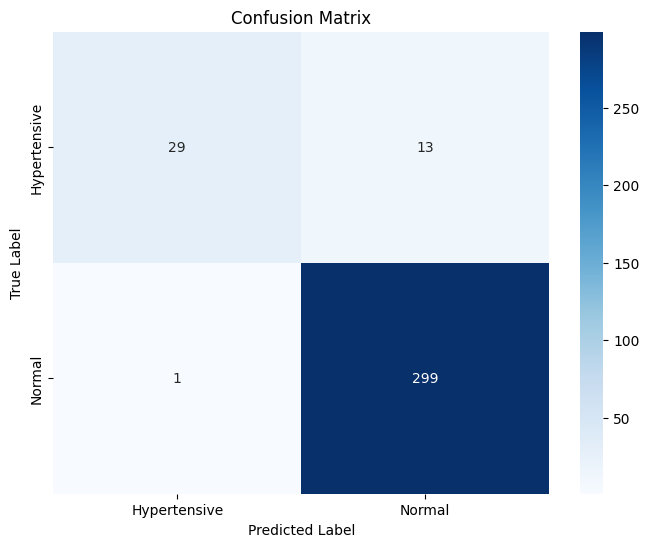

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the true labels from the test generator
true_labels = test_generator.classes

# Get the model's predictions
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten() # Convert probabilities to 0 or 1

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hypertensive', 'Normal'],
            yticklabels=['Hypertensive', 'Normal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels, target_names=['Hypertensive', 'Normal']))

              precision    recall  f1-score   support

Hypertensive       0.97      0.69      0.81        42
      Normal       0.96      1.00      0.98       300

    accuracy                           0.96       342
   macro avg       0.96      0.84      0.89       342
weighted avg       0.96      0.96      0.96       342



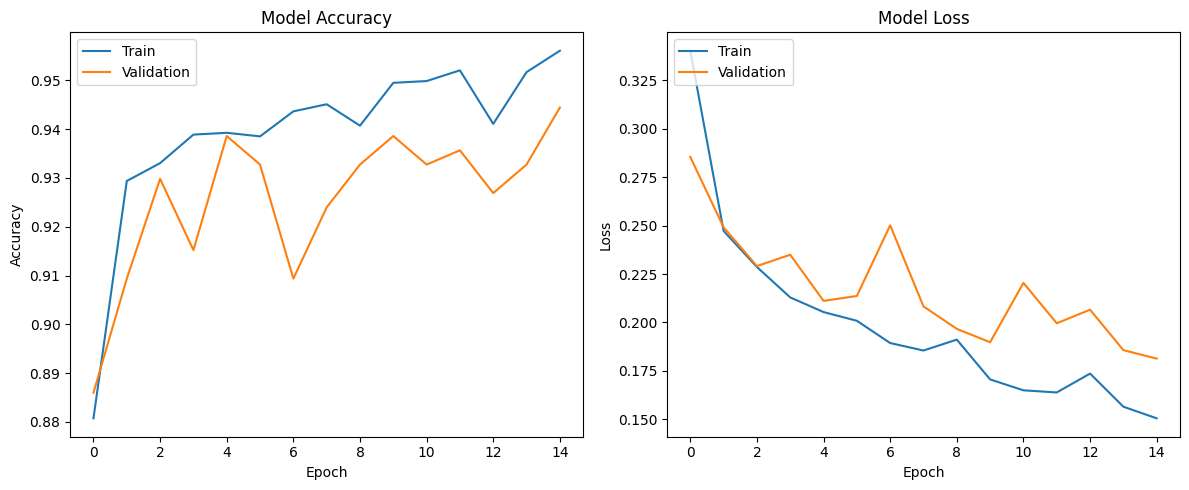

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()